In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Leitura de instâncias

In [2]:
def read_dat_file(file_path):
    """"Função para a leitura das instâncias geradas"""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 1. Lendo quantidade de itens e períodos
    items, periods = map(int, lines[0].split())

    # 2. Lendo número de plantas
    num_plants = int(lines[1].strip())

    # 3. Lendo capacidades das plantas
    capacities = [int(lines[i + 2].strip()) for i in range(num_plants)]
    capacities = np.tile(capacities, (periods, 1)).T  # Repete as capacidades ao longo dos períodos (deixar na forma j, t)

    # 4. Lendo a matriz de produção (tempo de produção, tempo de setup, custo de setup, custo de produção)
    production_data = []
    start_line = 2 + num_plants
    production_time = np.zeros((items, num_plants))  # Inicializar listas para armazenar separadamente os tempos e custos
    setup_time = np.zeros((items, num_plants))
    setup_cost = np.zeros((items, num_plants))
    production_cost = np.zeros((items, num_plants))
    for i in range(num_plants * items):  # Preencher as matrizes com os dados lidos
        plant = i // items  # Determina a planta
        item = i % items    # Determina o item
        # Extrair os dados de cada linha
        prod_time, set_time, set_cost, prod_cost = map(float, lines[start_line + i].split())
        production_time[item, plant] = prod_time  # Preencher as respectivas matrizes
        setup_time[item, plant] = set_time
        setup_cost[item, plant] = set_cost
        production_cost[item, plant] = prod_cost

    # 5. Lendo os custos de inventário
    inventory_costs_line = start_line + num_plants * items
    inventory_costs = list(map(float, lines[inventory_costs_line].split()))  # Lê todos os valores de inventory_costs como uma única lista
    inventory_costs = np.array(inventory_costs).reshape(num_plants, -1)  # Divide a lista de custos de inventário por planta
    inventory_costs = inventory_costs.T  # Deixa na forma (i, j)

    # 6. Lendo a matriz de demanda (12 linhas)
    demand_matrix = []
    demand_start_line = inventory_costs_line + 1
    
    # Leitura inicial das demandas
    for i in range(periods):  # Lê as linhas de demandas para os períodos
        demands = list(map(int, lines[demand_start_line + i].split()))
        demand_matrix.append(demands)
    
    # Agora vamos dividir os valores de cada linha combinada entre as plantas
    final_demand_matrix = []
    for demands in demand_matrix:
        period_demand = []
        for j in range(num_plants):
            # Divide a demanda combinada por planta, assumindo que cada planta tem o mesmo número de itens
            plant_demand = demands[j*items:(j+1)*items]
            period_demand.append(plant_demand)
        final_demand_matrix.append(period_demand)
    
    # Transpor a matriz de demanda para o formato correto (itens, plantas, períodos)
    final_demand_matrix = np.array(final_demand_matrix)
    final_demand_matrix = np.transpose(final_demand_matrix, (2, 1, 0))  # Converte para o formato (itens, plantas, períodos)

    # 7. Reading transfer costs directly from the document as a matrix
    transfer_cost_matrix = []
    transfer_cost_line = demand_start_line + periods

    # Read the matrix of transfer costs line by line
    while transfer_cost_line < len(lines):
        line = lines[transfer_cost_line].strip()
        if line:
            # Split the line into individual cost values and convert them to float
            row = [float(value) for value in line.split()]
            transfer_cost_matrix.append(row)
        transfer_cost_line += 1

    # Convert to a numpy array (optional, if you want to work with numpy for matrix operations)
    transfer_costs = np.array(transfer_cost_matrix)

    return {"items": items,
            "periods": periods,
            "num_plants": num_plants,
            "capacities": capacities,
            "production_time": production_time,
            "setup_time": setup_time,
            "setup_cost": setup_cost,  
            "production_cost": production_cost,
            "inventory_costs": inventory_costs,
            "demand_matrix": final_demand_matrix,
            "transfer_costs": transfer_costs}


In [3]:
# Exemplo de uso
# file_path = 'ABB03_12_20_120.dat'
file_path = '../instancias/conjunto1alt/AAB00_12_4_20.dat'
data = read_dat_file(file_path)
display(data)

{'items': 20,
 'periods': 12,
 'num_plants': 4,
 'capacities': array([[4243, 4243, 4243, 4243, 4243, 4243, 4243, 4243, 4243, 4243, 4243,
         4243],
        [4100, 4100, 4100, 4100, 4100, 4100, 4100, 4100, 4100, 4100, 4100,
         4100],
        [3702, 3702, 3702, 3702, 3702, 3702, 3702, 3702, 3702, 3702, 3702,
         3702],
        [3758, 3758, 3758, 3758, 3758, 3758, 3758, 3758, 3758, 3758, 3758,
         3758]]),
 'production_time': array([[4.2, 1.4, 3.5, 2. ],
        [4.2, 1.7, 4.8, 1.6],
        [1.6, 4.8, 1.6, 1.3],
        [3.2, 4.4, 3.1, 4.4],
        [1.9, 1.8, 4.5, 2.6],
        [3.9, 3. , 2.2, 3.2],
        [4.2, 1.8, 2. , 3.9],
        [4.2, 4. , 1.8, 3.5],
        [1.3, 4. , 2.1, 4. ],
        [1.4, 4.1, 3.1, 1.5],
        [3. , 2.4, 2.3, 3.1],
        [3.4, 2.6, 2.8, 3.3],
        [3.6, 3.6, 1.3, 2.7],
        [2.9, 3.6, 4.3, 4. ],
        [4.2, 2.7, 4. , 1.3],
        [4.8, 3.6, 4.2, 3.8],
        [3.3, 4.4, 1.2, 2.4],
        [1. , 1.8, 2.3, 1.3],
        [4.5,

# Modelagem

In [4]:
m = gp.Model('Lot-sizing Sambasivan and Yahya')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-13


## Conjuntos

In [5]:
# Produtos (i)
I = np.array([_ for _ in range(data['items'])])
# Plantas (j)
J = np.array([_ for _ in range(data['num_plants'])])
# Períodos (t)
T = np.array([_ for _ in range(data['periods'])])

## Parâmetros

In [6]:
# Demanda (i, j, t)
d = np.array(data['demand_matrix'])
# Capacidade (j, t)
cap = np.array(data['capacities'])
# Tempo de produção (i, j)
b = np.array(data['production_time'])
# Tempo de setup (i, j)
f = np.array(data['setup_time'])
# Custo de produção (i, j)
c = np.array(data['production_cost'])
# Custo de setup (i, j)
s = np.array(data['setup_cost'])
# Custo de transporte (j, k)
r = np.array(data['transfer_costs'])
# Custo de estoque (i, j)
h = np.array(data['inventory_costs'])

## Variáveis de decisão

In [7]:
# Quantidade produzida (i, j, t)
X = m.addVars(I, J, T, vtype=GRB.CONTINUOUS, name='X')
# Quantidade estocada (i, j, t)
Q = m.addVars(I, J, T, vtype=GRB.CONTINUOUS, name='Q')
# Quantidade transportada (i, j, k(um outro j), t)
W = m.addVars(I, J, J, T, vtype=GRB.CONTINUOUS, name='W')
# Variável de setup (binária) (i, j, t)
Z = m.addVars(I, J, T, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='Z')

## Função objetivo

In [8]:
expr_objetivo = sum(sum(sum(c[i, j] * X[i, j, t] + h[i, j] * Q[i, j, t] + s[i, j] * Z[i, j, t] + 
                            sum(r[j, k] * W[i, j, k, t] for k in J if k != j) for t in T) for j in J) for i in I)
m.setObjective(expr_objetivo, sense=GRB.MINIMIZE)

## Restrições

In [9]:
# Balanço de estoque (revisar comportamento)
# Período inicial
m.addConstrs((Q[i, j, t] == X[i, j, t] - sum(W[i, j, k, t] for k in J if k != j) + sum(W[i, l, j, t] for l in J if l != j) - d[i, j, t] for i in I for j in J for t in T if t == 0),
             name='restricao_balanco_estoque')
# Demais períodos
m.addConstrs((Q[i, j, t] == Q[i, j, t-1] + X[i, j, t] - sum(W[i, j, k, t] for k in J if k != j) + sum(W[i, l, j, t] for l in J if l != j) - d[i, j, t] for i in I for j in J for t in T if t > 0),
             name='restricao_balanco_estoque');

In [10]:
# Restrição que obriga setup (validar o range do r)
m.addConstrs((X[i, j, t] <= min((cap[j, t] - f[i, j]) / b[i, j], sum(sum(d[i, k, r] for r in range(t, T[-1] + 1)) for k in J)) * Z[i, j, t] for i in I for j in J for t in T)
             , name='restricao_setup');

In [11]:
# Restrição de capacidade
m.addConstrs((sum(b[i, j] * X[i, j, t] + f[i, j] * Z[i, j, t] for i in I) <= cap[j, t] for j in J for t in T)
             , name='restricao_capacidade');

In [12]:
m.update()
print(m)
print(m.Fingerprint)

<gurobi.Model Continuous instance Lot-sizing Sambasivan and Yahya: 1968 constrs, 6720 vars, Parameter changes: Username=(user-defined)>
1384351974


# Relax and fix

In [13]:
# m.Params.timelimit = 100
# for i in I:
#     for j in J:
#         for t in T:
#             Z[i, j, t].setAttr("VType", GRB.BINARY)
# m.optimize()

In [14]:
# Parâmetros
w = 4  # Número de períodos na janela de resolução
y = 3  # Número de períodos em overlap

K = np.ceil((len(T) - w) / (w - y)) + 1  # Número total de iterações
m.params.OutputFlag = 1
m.Params.timelimit = 300 / K  # Tempo limite por subproblema (s)
runtime = 0

# Auxiliares
k, to, tf = 1, 0, w
N = T[-1]  # Último período do horizonte de planejamento

# Relaxar domínio das variáveis binárias (Z_ijt)
# for key in Z.keys():
#     Z[key].setAttr("VType", GRB.CONTINUOUS)
#     Z[key].setAttr("LB", 0)
#     Z[key].setAttr("UB", 1)
# m.update()

print('k:', k, 'to:', to, 'tf:', tf)

# Main loop
while tf <= N:
    # Variáveis na janela tornam-se binárias
    for i in I:
        for j in J:
            for t in range(to, tf):
                Z[i, j, t].setAttr("VType", GRB.BINARY)

    # Resolução do subprolema
    m.optimize()
    print('Status:', m.Status)
    print('SolCount:', m.SolCount)
    if m.Status == GRB.INFEASIBLE or m.SolCount == 0:
        break
    # Fixação das soluções obtidas considerando overlap
    for i in I:
        for j in J:
            for t in range(to, tf - y):
                Z[i, j, t].setAttr("LB", Z[i, j, t].X)  # Lower bound fixado para a solução encontrada
                Z[i, j, t].setAttr("UB", Z[i, j, t].X)  # Upper bound fixado para a solução encontrada

    # Atualização dos auxiliares
    k += 1
    to = tf - y
    tf = min(tf + w - y, N + 1)

    print('k:', k, 'to:', to, 'tf:', tf)

# Última iteração
if m.Status != GRB.INFEASIBLE and m.SolCount > 0:
    # Variáveis na janela tornam-se binárias
    for i in I:
        for j in J:
            for t in range(to, tf):
                Z[i, j, t].setAttr("VType", GRB.BINARY)
    m.update()

    # Última resolução
    m.optimize()
    print('Status:', m.Status)
    print('SolCount:', m.SolCount)
print('-------------------')
print('STATUS:', m.Status)
print(m.SolCount)

Set parameter TimeLimit to value 3.3333333333333336e+01
k: 1 to: 0 tf: 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1968 rows, 6720 columns and 12400 nonzeros
Model fingerprint: 0x4aace06f
Variable types: 6400 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-01, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 640 rows and 1680 columns
Presolve time: 0.04s
Presolved: 1328 rows, 5040 columns, 10400 nonzeros
Variable types: 4720 continuous, 320 integer (320 binary)

Root relaxation: objective 3.447876e+05, 3796 iterations, 0.33 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

In [15]:
m.ObjVal

inf

# Investigação do caráter das demandas

A média das demandas de um produto i é igual entre períodos t ao agregar a demanda entre plantas?

In [16]:
# Produtos
I

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [17]:
# Plantas
J

array([0, 1, 2, 3])

In [18]:
# Períodos
T

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [19]:
# Demanda por produto por período
demanda_agregada = np.zeros(shape=(len(I), len(T)))
for i in I:
    for t in T:
        demanda_agregada[i, t] = sum(d[i, j, t] for j in J)

In [20]:
demanda_agregada

array([[320., 324., 414., 403., 318., 494., 396., 501., 514., 409., 482.,
        365.],
       [245., 242., 271., 361.,  92., 494., 300., 418., 439., 219., 340.,
        335.],
       [360., 207., 534., 359., 448., 288., 398., 172., 528., 483., 405.,
        266.],
       [461., 360., 345., 285., 384., 554., 418., 261., 408., 377., 391.,
        234.],
       [234., 259., 356., 540., 368., 377., 438., 437., 368., 391., 421.,
        392.],
       [318., 340., 522., 535., 185., 306., 482., 266., 362., 345., 151.,
        381.],
       [516., 243., 260., 345., 283., 527., 447., 419., 432., 285., 285.,
        282.],
       [513., 252., 369., 264., 375., 440., 335., 173., 211., 200., 433.,
        289.],
       [195., 546., 380., 295., 272., 244., 410., 210., 156., 402., 428.,
        329.],
       [271., 435., 363., 277., 366., 333., 380., 261., 301., 430., 440.,
        254.],
       [438., 424., 540., 480., 361., 271., 446., 324., 320., 339., 475.,
        530.],
       [418., 350., 4

In [21]:
average_demand_product = np.zeros(len(I))
for i in I:
    average_demand_product[i] = demanda_agregada[i].sum()

In [22]:
demanda_agregada[7]

array([513., 252., 369., 264., 375., 440., 335., 173., 211., 200., 433.,
       289.])

In [23]:
from scipy import stats

# Array de exemplo
data = demanda_agregada[7]

# Teste de Shapiro-Wilk
stat, p_value = stats.shapiro(data)
print(f"Estatística do teste: {stat}, Valor-p: {p_value}")

if p_value > 0.05:
    print("A distribuição parece ser normal (não rejeitamos H0).")
else:
    print("A distribuição não é normal (rejeitamos H0).")

Estatística do teste: 0.9597059852804234, Valor-p: 0.7796240205967417
A distribuição parece ser normal (não rejeitamos H0).


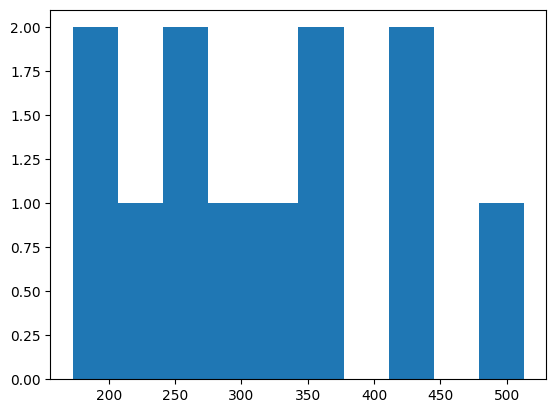

In [24]:
plt.hist(demanda_agregada[7])
plt.show()

In [25]:
average_demand_period = np.zeros(len(T))
for t in T:
    average_demand_period[t] = demanda_agregada.transpose()[t].sum()

In [26]:
average_demand_period

array([6979., 6871., 7587., 7726., 6599., 7253., 8118., 6677., 7483.,
       7250., 7612., 7102.])

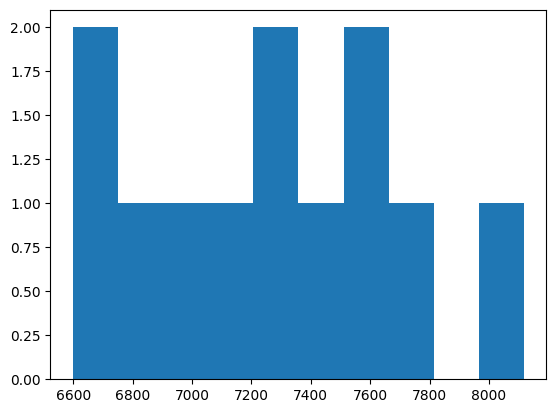

In [27]:
plt.hist(average_demand_period)
plt.show()

In [28]:
from scipy import stats

# Array de exemplo
data = average_demand_period

# Teste de Shapiro-Wilk
stat, p_value = stats.shapiro(data)
print(f"Estatística do teste: {stat}, Valor-p: {p_value}")

if p_value > 0.05:
    print("A distribuição parece ser normal (não rejeitamos H0).")
else:
    print("A distribuição não é normal (rejeitamos H0).")

Estatística do teste: 0.9752681687028535, Valor-p: 0.9574636851479719
A distribuição parece ser normal (não rejeitamos H0).
